# Wildfires in the United States
Samantha Maillie and Ariel Sim

# Background

Every year wildfires cost billions which is hardly comparable to the lives lost from wildfires, (1). Utilizing an SQL database containing information on 1.88 million wildfires nationwide we want to investigate if we are able to predict the cause of the fire by examine size and location. Why is this important? Understanding this relationship deeper can help fine tune policies designed to prevent wildfires. Once these blazes get to a certain point it gets very difficult to control them which means our best bet in protecting ourselves is making sure they never begin. If they do begin we need to have the information to implement proper evacuation procedures that covers the appropriate area, understanding these relationships could offer insight into this problem as well. 

Our plan is to do some preliminary analysis to determine which classifications algorithms best suit our problem. We will then implement the relevant procedures and compare them using numerous methods including k-fold cross validation and confusion matrices. 

Why this dataset? We wanted a dataset that could offer insight into a problem we are familiar with. This dataset found at the link below is large, informative and not excessively worked over like many of the datasets easily accessible online. This offers us the opportunity to discover new conclusions from the dataset as opposed to essentially replicating results. 

# Dataset Description

This dataset was originally designed for the use of the Fire Protection Agency, (FPA). It contains 1.88 million datapoints with information on wildfires nationwide between the years 1992 and 2015, (2). The goal of this datset's publication on kaggle is to investigate the relationship between the size, location and cause of wildfires, (2). Our project aims to tackle this problem. 

The database in considerably large and can be downloaded via this link: 
https://www.kaggle.com/rtatman/188-million-us-wildfires

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
import sqlite3 as sql
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
db = sql.connect("FPA_FOD_20170508.sqlite")

In [4]:
cursor = db.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('spatial_ref_sys',), ('spatialite_history',), ('sqlite_sequence',), ('geometry_columns',), ('spatial_ref_sys_aux',), ('views_geometry_columns',), ('virts_geometry_columns',), ('geometry_columns_statistics',), ('views_geometry_columns_statistics',), ('virts_geometry_columns_statistics',), ('geometry_columns_field_infos',), ('views_geometry_columns_field_infos',), ('virts_geometry_columns_field_infos',), ('geometry_columns_time',), ('geometry_columns_auth',), ('views_geometry_columns_auth',), ('virts_geometry_columns_auth',), ('sql_statements_log',), ('SpatialIndex',), ('ElementaryGeometries',), ('KNN',), ('Fires',), ('idx_Fires_Shape',), ('idx_Fires_Shape_node',), ('idx_Fires_Shape_rowid',), ('idx_Fires_Shape_parent',), ('NWCG_UnitIDActive_20170109',)]


In [5]:
fire = pd.read_sql_query("SELECT * FROM 'Fires'", db)
print(fire.head())

   OBJECTID  FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
0         1       1  FS-1418826                FED   FS-FIRESTAT   
1         2       2  FS-1418827                FED   FS-FIRESTAT   
2         3       3  FS-1418835                FED   FS-FIRESTAT   
3         4       4  FS-1418845                FED   FS-FIRESTAT   
4         5       5  FS-1418847                FED   FS-FIRESTAT   

  NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME  \
0                    FS                USCAPNF    Plumas National Forest   
1                    FS                USCAENF  Eldorado National Forest   
2                    FS                USCAENF  Eldorado National Forest   
3                    FS                USCAENF  Eldorado National Forest   
4                    FS                USCAENF  Eldorado National Forest   

  SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME  \
0                  0511     Plumas National Forest   
1                  0503   

In [6]:
fire.shape

(1880465, 39)

In [7]:
fire.dtypes

OBJECTID                        int64
FOD_ID                          int64
FPA_ID                         object
SOURCE_SYSTEM_TYPE             object
SOURCE_SYSTEM                  object
NWCG_REPORTING_AGENCY          object
NWCG_REPORTING_UNIT_ID         object
NWCG_REPORTING_UNIT_NAME       object
SOURCE_REPORTING_UNIT          object
SOURCE_REPORTING_UNIT_NAME     object
LOCAL_FIRE_REPORT_ID           object
LOCAL_INCIDENT_ID              object
FIRE_CODE                      object
FIRE_NAME                      object
ICS_209_INCIDENT_NUMBER        object
ICS_209_NAME                   object
MTBS_ID                        object
MTBS_FIRE_NAME                 object
COMPLEX_NAME                   object
FIRE_YEAR                       int64
DISCOVERY_DATE                float64
DISCOVERY_DOY                   int64
DISCOVERY_TIME                 object
STAT_CAUSE_CODE               float64
STAT_CAUSE_DESCR               object
CONT_DATE                     float64
CONT_DOY    

# Preliminary Analysis

## NA's this section might be irrelevant just left in so I didn't have to retype if we needed it

In [8]:
fire.isnull().sum()

OBJECTID                            0
FOD_ID                              0
FPA_ID                              0
SOURCE_SYSTEM_TYPE                  0
SOURCE_SYSTEM                       0
NWCG_REPORTING_AGENCY               0
NWCG_REPORTING_UNIT_ID              0
NWCG_REPORTING_UNIT_NAME            0
SOURCE_REPORTING_UNIT               0
SOURCE_REPORTING_UNIT_NAME          0
LOCAL_FIRE_REPORT_ID          1459286
LOCAL_INCIDENT_ID              820821
FIRE_CODE                     1555636
FIRE_NAME                      957189
ICS_209_INCIDENT_NUMBER       1854748
ICS_209_NAME                  1854748
MTBS_ID                       1869462
MTBS_FIRE_NAME                1869462
COMPLEX_NAME                  1875282
FIRE_YEAR                           0
DISCOVERY_DATE                      0
DISCOVERY_DOY                       0
DISCOVERY_TIME                 882638
STAT_CAUSE_CODE                     0
STAT_CAUSE_DESCR                    0
CONT_DATE                      891531
CONT_DOY    

looks like its all or nothing for this groups:
county/Fips code/ fips name
cont date/ cont doy
mtbs id/ mtbs fire name
ICS incident number 
ICS name

are some of these variables irrelevant? some look more like book keeping measures than predictors

In [9]:
fire = fire.drop(['LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID','FIRE_CODE', 'FIRE_NAME' ], axis=1)
fire = fire.drop(['ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME','MTBS_ID', 'MTBS_FIRE_NAME','COMPLEX_NAME' ], axis=1)
fire = fire.drop(['DISCOVERY_TIME', 'CONT_DATE','CONT_DOY', 'CONT_TIME' ], axis=1)
fire = fire.drop(['COUNTY', 'FIPS_CODE','FIPS_NAME' ], axis=1)

In [10]:
fire.isnull().sum()

OBJECTID                      0
FOD_ID                        0
FPA_ID                        0
SOURCE_SYSTEM_TYPE            0
SOURCE_SYSTEM                 0
NWCG_REPORTING_AGENCY         0
NWCG_REPORTING_UNIT_ID        0
NWCG_REPORTING_UNIT_NAME      0
SOURCE_REPORTING_UNIT         0
SOURCE_REPORTING_UNIT_NAME    0
FIRE_YEAR                     0
DISCOVERY_DATE                0
DISCOVERY_DOY                 0
STAT_CAUSE_CODE               0
STAT_CAUSE_DESCR              0
FIRE_SIZE                     0
FIRE_SIZE_CLASS               0
LATITUDE                      0
LONGITUDE                     0
OWNER_CODE                    0
OWNER_DESCR                   0
STATE                         0
Shape                         0
dtype: int64

## Split into Train/Test

In [11]:
X = fire[['STATE', 'FIRE_SIZE_CLASS' ]]

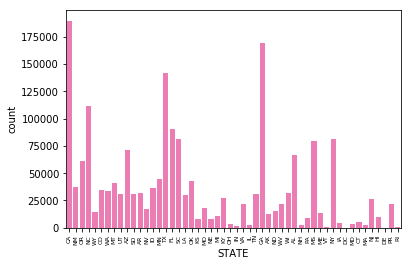

In [12]:
sns.countplot(X['STATE'], color = "hotpink")
plt.xticks(rotation=90, fontsize=6)
plt.show()

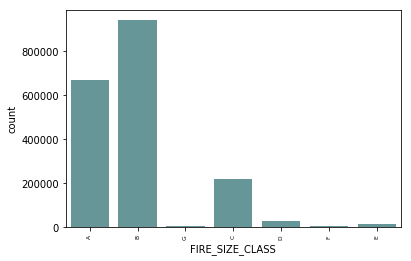

In [13]:
sns.countplot(X['FIRE_SIZE_CLASS'], color = "cadetblue")
plt.xticks(rotation=90, fontsize=6)
plt.show()

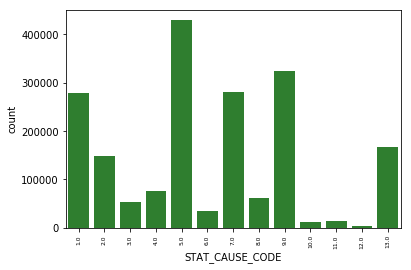

In [14]:
sns.countplot(fire['STAT_CAUSE_CODE'], color = "forestgreen")
plt.xticks(rotation=90, fontsize=6)
plt.show()

In [15]:
X.isnull().sum()

STATE              0
FIRE_SIZE_CLASS    0
dtype: int64

In [16]:
X = pd.get_dummies(X)

In [17]:
y = fire['STAT_CAUSE_CODE']

In [18]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42)

# Bayes Model

In [19]:
X_tr.dtypes

STATE_AK             uint8
STATE_AL             uint8
STATE_AR             uint8
STATE_AZ             uint8
STATE_CA             uint8
STATE_CO             uint8
STATE_CT             uint8
STATE_DC             uint8
STATE_DE             uint8
STATE_FL             uint8
STATE_GA             uint8
STATE_HI             uint8
STATE_IA             uint8
STATE_ID             uint8
STATE_IL             uint8
STATE_IN             uint8
STATE_KS             uint8
STATE_KY             uint8
STATE_LA             uint8
STATE_MA             uint8
STATE_MD             uint8
STATE_ME             uint8
STATE_MI             uint8
STATE_MN             uint8
STATE_MO             uint8
STATE_MS             uint8
STATE_MT             uint8
STATE_NC             uint8
STATE_ND             uint8
STATE_NE             uint8
STATE_NH             uint8
STATE_NJ             uint8
STATE_NM             uint8
STATE_NV             uint8
STATE_NY             uint8
STATE_OH             uint8
STATE_OK             uint8
S

## I beat that guy doing decision trees in R :) he only got .5  

In [20]:
bclf = GaussianNB()
bclf.fit(X_tr, y_tr.values.ravel())
bclf.score(X_te, y_te.values.ravel())

0.072701051014960105

# Model Validation
k fold cv, ROC curves, confusion matrices, precision recall

In [21]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
scoring = 'accuracy'
results = model_selection.cross_val_score(bclf, X_tr, y_tr.values.ravel(), cv=kfold, scoring=scoring)
print("10-fold cross validation for Bayesian average accuracy: %.3f" % (results.mean()))

10-fold cross validation for Bayesian average accuracy: 0.071


## Need to cells bigger or something

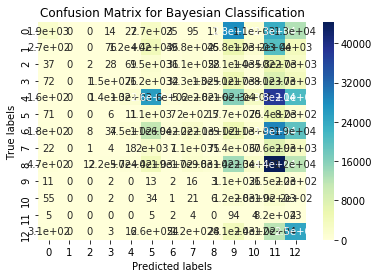

In [22]:
predB = bclf.predict(X_te)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, predB)
np.set_printoptions(precision=2)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Bayesian Classification'); 
plt.show()

# Need the Precision - Recall Curve Code

In [23]:
from sklearn import metrics
print(metrics.classification_report(y_te, predB))

             precision    recall  f1-score   support

        1.0       0.54      0.03      0.05     69992
        2.0       0.00      0.00      0.00     36910
        3.0       0.08      0.00      0.00     13081
        4.0       0.22      0.01      0.02     19130
        5.0       0.45      0.01      0.02    107147
        6.0       0.02      0.13      0.04      8479
        7.0       0.41      0.01      0.02     69991
        8.0       0.15      0.08      0.10     15251
        9.0       0.53      0.01      0.02     80898
       10.0       0.01      0.39      0.03      2877
       11.0       0.03      0.08      0.04      3645
       12.0       0.00      0.84      0.01       981
       13.0       0.24      0.59      0.34     41735

avg / total       0.37      0.07      0.06    470117



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## MultiClass Logistic Classification taking forever


In [24]:
#logisticRegr = LogisticRegression(multi_class='multinomial', solver = 'newton-cg')
#logisticRegr.fit(X_tr, y_tr.values.ravel())
#predictions = logisticRegr.predict(X_te)
#logisticRegr.score(X_te, y_te.values.ravel())

# Might be good to keep these to show a bad classification. We could try to think of why they are failing and discuss that.

# Random Forest

In [25]:
RFclf = RandomForestClassifier(max_depth=2, random_state=0)
RFclf.fit(X_tr, y_tr.values.ravel()) 
RFclf.score(X_te, y_te.values.ravel())

0.29449052044491053

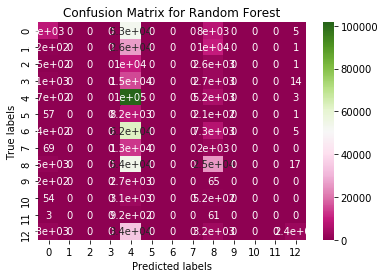

In [26]:
predRF = RFclf.predict(X_te)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, predRF)
np.set_printoptions(precision=2)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax, cmap="PiYG"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Random Forest'); 
plt.show()

In [29]:
print(metrics.classification_report(y_te, predRF))

             precision    recall  f1-score   support

        1.0       0.60      0.13      0.21     69992
        2.0       0.00      0.00      0.00     36910
        3.0       0.00      0.00      0.00     13081
        4.0       0.00      0.00      0.00     19130
        5.0       0.26      0.95      0.41    107147
        6.0       0.00      0.00      0.00      8479
        7.0       0.00      0.00      0.00     69991
        8.0       0.00      0.00      0.00     15251
        9.0       0.38      0.31      0.34     80898
       10.0       0.00      0.00      0.00      2877
       11.0       0.00      0.00      0.00      3645
       12.0       0.00      0.00      0.00       981
       13.0       0.98      0.06      0.11     41735

avg / total       0.30      0.29      0.19    470117



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
results = model_selection.cross_val_score(RFclf, X_tr, y_tr.values.ravel(), cv=kfold, scoring=scoring)
print("10-fold cross validation for Bayesian average accuracy: %.3f" % (results.mean()))

10-fold cross validation for Bayesian average accuracy: 0.295


# Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier
DTclf = DecisionTreeClassifier(random_state=0)
DTclf.fit(X_tr, y_tr.values.ravel()) 
DTclf.score(X_te, y_te.values.ravel())

0.41313332638470851

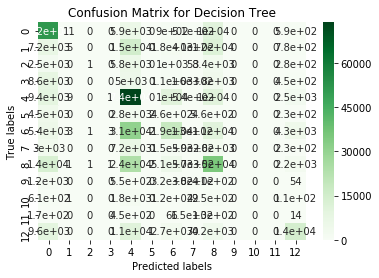

In [28]:
predDT = DTclf.predict(X_te)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_te, predDT)
np.set_printoptions(precision=2)
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, ax = ax, cmap="Greens"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix for Decision Tree'); 
plt.show()

In [30]:
print(metrics.classification_report(y_te, predDT))

             precision    recall  f1-score   support

        1.0       0.44      0.74      0.55     69992
        2.0       0.17      0.00      0.00     36910
        3.0       0.33      0.00      0.00     13081
        4.0       0.00      0.00      0.00     19130
        5.0       0.40      0.69      0.51    107147
        6.0       0.29      0.00      0.00      8479
        7.0       0.42      0.26      0.32     69991
        8.0       0.16      0.04      0.06     15251
        9.0       0.37      0.43      0.40     80898
       10.0       0.00      0.00      0.00      2877
       11.0       0.00      0.00      0.00      3645
       12.0       0.00      0.00      0.00       981
       13.0       0.55      0.35      0.43     41735

avg / total       0.37      0.41      0.35    470117



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
results = model_selection.cross_val_score(DTclf, X_tr, y_tr.values.ravel(), cv=kfold, scoring=scoring)
print("10-fold cross validation for Bayesian average accuracy: %.3f" % (results.mean()))

# Conclusions

# Future Research

# Sources

1. Press, Associated. “The Costs to Fight the Deadly Wildfires in the West Are Spiraling out of Control.” Business Insider, Business Insider, 15 Oct. 2017, www.businessinsider.com/ap-us-states-struggle-to-pay-spiraling-cost-of-fighting-fires-2017-10.

2. Tatman, Rachael. “1.88 Million US Wildfires | Kaggle.” Countries of the World | Kaggle, 13 Sept. 2017, www.kaggle.com/rtatman/188-million-us-wildfires.

# Note to Sam: get sources from 141 project as well